# Maps of SWCF from Obs and Models

In [2]:
import os
import math
import xarray as xr
import numpy as np
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from typing import List, Tuple
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress

# Utils

In [3]:
def global_plot(ax, data, lon, lat, cmap, pvalues=None, winds=None, right_title="", left_title="", levels=np.arange(-4, 4.1, .1), cbar_label: str = ""):
    # plot map of global data with central longitude 180
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        levels=levels,
    )
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    if winds is not None: 
        # quiver([X, Y], U, V, [C], **kwargs)
        ax.quiver(lon[::3], lat[::3], winds["U10"][::3,::3], winds["V10"][::3,::3], scale=20, transform=ccrs.PlateCarree())
    
    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)
    bound_region(ax, lons=(-105, -70), lats=(-40, -10), color="black")

    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
        
    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -65, 65
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    return img

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

def get_agreement(swcf_obs, swcf_cmip):
   # Count where models and obs agree
   agreement_count = xr.where(
      ((swcf_obs > 0) & (swcf_cmip["swcf"] > 0)) |
      ((swcf_obs < 0) & (swcf_cmip["swcf"] < 0)), 
      1,
      0
   ).sum("model")
   # If count is half or more of models, then pvalue is 0
   pvalues = xr.where(
      agreement_count >= math.ceil(len(swcf_cmip.model.values)/2),
      0, # Agree 
      1, # Disagree
   )
   return pvalues

# Load Data

In [6]:
def load_swcf(feedback: str ="swcf", toa: bool = True):
    """Load SWCF defined for surface or TOA"""
    if toa:
        swcf_cmip6 = xr.open_dataset(f"/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf_cmip6_monthly_1850-2000.nc", chunks="auto").rename({"lat": "latitude", "lon": "longitude"})
        swcf_cmip5 = xr.open_dataset(f"/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf_cmip5_monthly_1850-2000.nc", chunks="auto").rename({"lat": "latitude", "lon": "longitude"})

        swcf_cmip6_epsa = xr.open_dataset(f"/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf_east_sa_cmip6_v3.nc")
        swcf_cmip5_epsa = xr.open_dataset(f"/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf_east_sa_cmip5_v3.nc")

        swcf_obs = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/obs/swcf_toa_obs.nc")
        swcf_epsa_obs = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/obs/swcf_toa_epsa_obs.nc")
    else:
        swcf_obs = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/obs/swcf_surface_obs.nc")
        swcf_epsa_obs = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/obs/swcf_surface_epsa_obs.nc")

        swcf_cmip6 = xr.open_dataset(f"/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf-surface-cmip6_monthly_1850-2000.nc", chunks="auto").rename({"lat": "latitude", "lon": "longitude"})
        swcf_cmip5 = xr.open_dataset(f"/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf-surface-cmip5_monthly_1850-2000.nc", chunks="auto").rename({"lat": "latitude", "lon": "longitude"})

        swcf_cmip6_epsa = xr.open_dataset(f"/home/espinosa10/tropical_pacific_clouds/data/piControl/cf_east_sa_swcf-surface_cmip6_v3.nc")
        swcf_cmip5_epsa = xr.open_dataset(f"/home/espinosa10/tropical_pacific_clouds/data/piControl/cf_east_sa_swcf-surface_cmip5_v3.nc")

    return swcf_cmip6, swcf_cmip5, swcf_cmip6_epsa, swcf_cmip5_epsa, swcf_obs, swcf_epsa_obs

    
swcf_cmip6, swcf_cmip5, swcf_cmip6_epsa, swcf_cmip5_epsa, swcf_obs, swcf_epsa_obs = load_swcf(toa=True)

# Figure SX
Map of local SWCF from Obs and Models

In [13]:
swcf_cmip = xr.concat([swcf_cmip5, swcf_cmip6], dim="model")
swcf_cmip_epsa = xr.concat([swcf_cmip5_epsa, swcf_cmip6_epsa], dim="model")

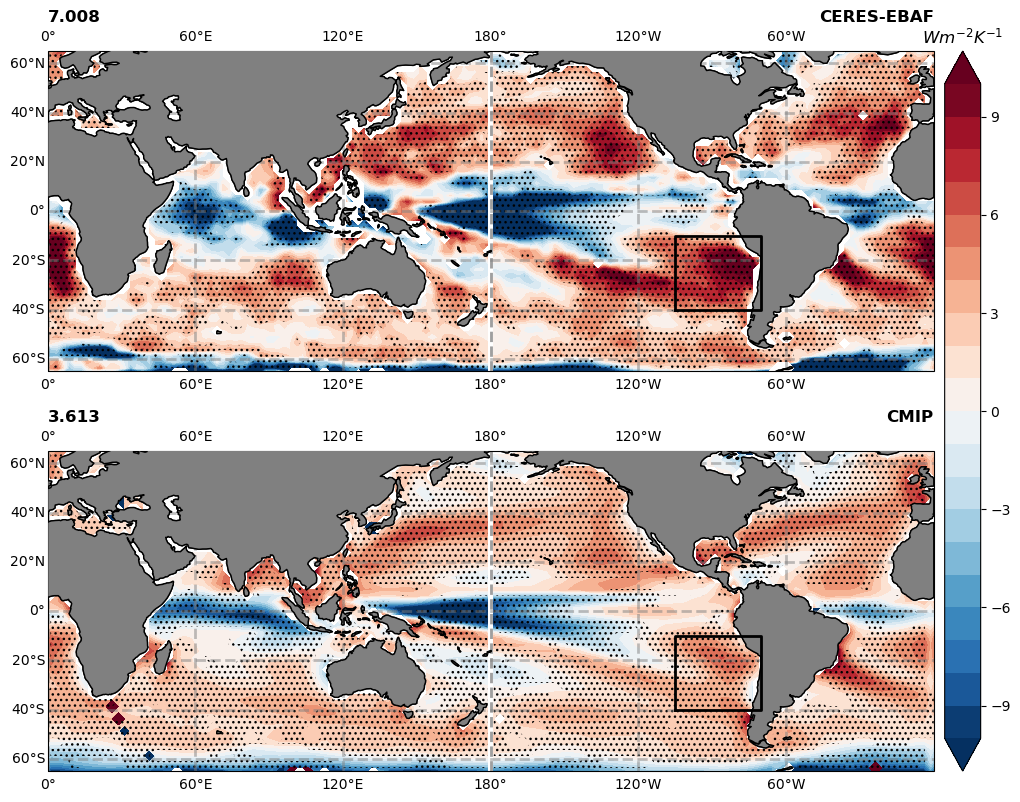

In [15]:
fig = plt.figure(figsize=(12,8))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree(central_longitude=180))
fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, hspace=.25, wspace=0.15)


levels = np.arange(-10, 11, 1)
cmap = "RdBu_r"

img = global_plot(
    ax1,
    data=swcf_obs["PCMDI-AMIP-1-1-9"],
    lat=swcf_obs["PCMDI-AMIP-1-1-9"].latitude,
    lon=swcf_obs["PCMDI-AMIP-1-1-9"].longitude,
    pvalues=swcf_obs["PCMDI-AMIP-1-1-9-pvalues"],
    levels=levels,
    cmap=cmap, 
    cbar_label="K/30yr"
)

# Set pvalues equal to 0 where majority of models in SWCF_CMIP6 agree with sign of SWCF_Obs
pvalues_cmip = get_agreement(swcf_obs=swcf_obs["PCMDI-AMIP-1-1-9"], swcf_cmip=swcf_cmip)


# Plot Figure S2b: SWCF CMIP6
img = global_plot(
    ax2,
    data=swcf_cmip["swcf"].mean("model"),
    lat=swcf_cmip.latitude,
    lon=swcf_cmip.longitude,
    pvalues=pvalues_cmip,
    levels=levels,
    cmap=cmap, 
    cbar_label="K/30yr"
)

# Set Right Title: Name of Product
title_fontsize = 12
ax1.set_title("CERES-EBAF", loc="right", fontweight="bold", fontsize=title_fontsize)
ax2.set_title("CMIP", loc="right", fontweight="bold", fontsize=title_fontsize)

# Set Left Title: Area Weighted SWCF in EPSA
epsa = np.around(swcf_cmip_epsa["swcf"].mean("model").values, 3)
epsaObs = np.around(swcf_epsa_obs["PCMDI-AMIP-1-1-9"].values, 3)
ax1.set_title(epsaObs, loc="left", fontweight="bold", fontsize=title_fontsize)
ax2.set_title(epsa, loc="left", fontweight="bold", fontsize=title_fontsize)

cbar = fig.colorbar(img, ax=[ax1, ax2], orientation='vertical', location="right", fraction=.1, pad=0.01)
cbar.ax.set_title(r"$Wm^{-2}K^{-1}$", fontsize=12, fontweight="bold")

#########################################################################
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/SI/Figure_SX_SWCF-Maps.png", dpi=300, bbox_inches="tight")
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/SI/Figure_SX_SWCF-Maps.pdf", dpi=300, bbox_inches="tight")